---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [1]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [2]:
# Task 1b: Verify API keys
response = litellm.completion(
    model="gpt-4o-mini",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

API working!


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [3]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [4]:
# Task 2a: Load the data
df_products = load_wands_products()
df_queries = load_wands_queries()
df_labels = load_wands_labels()


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [5]:
# YOUR CODE HERE
print(df_products.columns.to_list())
df_products.head(3)
# product_name, product_class, product_description, category seem useful because they are distinct and meaningful towards the product

['product_id', 'product_name', 'product_class', 'category_hierarchy', 'product_description', 'product_features', 'rating_count', 'average_rating', 'review_count']


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0


In [6]:
# YOUR CODE HERE
print(df_labels.columns.to_list())
df_labels.head(3)


['id', 'query_id', 'product_id', 'label', 'grade']


,id,query_id,product_id,label,grade
0,0,0,25434,Exact,2
1,1,0,12088,Irrelevant,0
2,2,0,42931,Exact,2


In [7]:
# YOUR CODE HERE
print(df_queries.columns.to_list())
df_queries.head(3)

['query_id', 'query', 'query_class']


,query_id,query,query_class
0,0,salon chair,Massage Chairs
1,1,smart coffee table,Coffee & Cocktail Tables
2,2,dinosaur,Kids Wall Décor


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

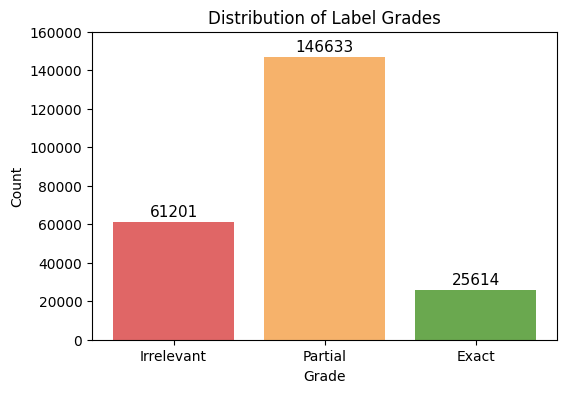

In [8]:
# Task 2c: Understand judgments
import matplotlib.pyplot as plt

# Plot the distribution of label grades
grade_counts = df_labels['grade'].value_counts().sort_index()
grade_names = {0: "Irrelevant", 1: "Partial", 2: "Exact"}

plt.figure(figsize=(6,4))
plt.bar([grade_names[g] for g in grade_counts.index], grade_counts.values, color=["#e06666", "#f6b26b", "#6aa84f"])
# Annotate each bar with its total count
for i, count in enumerate(grade_counts.values):
    plt.text(i, count + max(grade_counts.values)*0.01, str(count), ha='center', va='bottom', fontsize=11)

plt.title("Distribution of Label Grades")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.ylim(0, 160000)
plt.xticks(rotation=0)
plt.show()

---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [9]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [10]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [11]:
query_word = 'ball'
# Task 3a: Create BM25 index for product_name
index, doc_lengths = build_index(df_products['product_name'], snowball_tokenize)
# YOUR CODE HERE

search_results = search_products(query_word, df_products, index, doc_lengths, snowball_tokenize)


In [12]:
search_results

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
30034,30034,balance ball chair,Office Stools,Furniture / Office Furniture / Office Stools /...,extended periods of sitting can wreak havoc on...,producttype : ball chair|weightcapacity:300|up...,109.0,4.5,78.0,8.885482,1
29900,29900,ball shower hooks,Shower Curtain Hooks and Accessories,Bed & Bath / Shower Curtains & Accessories / S...,NaN,overallwidth-sidetoside:1.5|theme : modern|pro...,92.0,4.5,45.0,8.885482,2
6054,6054,ergonomic ball chair,Office Stools,Furniture / Office Furniture / Office Stools /...,sitting on a stability ball can improve stabil...,warrantylength:1 year|overalldepth-fronttoback...,18.0,4.5,14.0,8.885482,3
9220,9220,ball shower curtain hooks,Shower Curtain Hooks and Accessories,Bed & Bath / Shower Curtains & Accessories / S...,create a designer touch in your bath with easy...,lsbinvestmentskus : birchlane|theme : modern|p...,293.0,4.5,126.0,8.224297,4
9219,9219,rounds ball shower curtain hooks,Shower Curtain Hooks and Accessories,Bed & Bath / Shower Curtains & Accessories / S...,fashions color rounds ball shower curtain hook...,producttype : shower curtain hook|primarymater...,265.0,4.5,151.0,7.654696,5
20232,20232,party ball usb table light,NaN,Lighting / Wall Lights / Night Lights,"when you want to make any moment fun , the lig...",material : plastic|overallproductweight:0.22|p...,5.0,3.5,4.0,7.654696,6
37298,37298,winooski root ball end table,End Tables,Furniture / Living Room Furniture / Coffee Tab...,NaN,style : coastal|overallheight-toptobottom:24|b...,31.0,4.5,24.0,7.654696,7
38146,38146,ball aluminum shower curtain hooks,Shower Curtain Hooks and Accessories,Bed & Bath / Shower Curtains & Accessories / S...,NaN,overalldepth-fronttoback:0.73|color : black|th...,75.0,4.5,47.0,7.654696,8
5784,5784,keeva round ball patio chair,Patio Lounge Chairs,Outdoor / Outdoor & Patio Furniture / Outdoor ...,futuristic design and novel colors correspond ...,overallwidth-sidetoside:23|warrantylength:90 d...,90.0,4.5,67.0,7.654696,9
9226,9226,crystal ball shower curtain hooks,Shower Curtain Hooks and Accessories,Bed & Bath / Shower Curtains & Accessories / S...,add a splash of color in your bathroom with th...,theme : glam|producttype : shower curtain hook...,58.0,4.5,33.0,7.654696,10


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [13]:
# Task 3b: Add product_description to search

# YOUR CODE HERE
second_index, sec_doc_lengths = build_index(df_products['product_description'], snowball_tokenize)

search_results_desc = search_products(query_word, df_products, second_index, sec_doc_lengths, snowball_tokenize)


In [14]:
search_results_desc

,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank
6054,6054,ergonomic ball chair,Office Stools,Furniture / Office Furniture / Office Stools /...,sitting on a stability ball can improve stabil...,warrantylength:1 year|overalldepth-fronttoback...,18.0,4.5,14.0,8.474685,1
34743,34743,disco ball bead single polka dot curtain,Curtains & Drapes,Décor & Pillows / Window Treatments / Curtains...,celebrate mardi gras with this disco ball bead...,pattern : polka dots|producttype : curtain|lif...,10.0,2.5,9.0,7.216174,2
843,843,stonge 6 drawer double dresser,Dressers & Chests,Furniture / Bedroom Furniture / Dressers & Chests,the classic 6 drawer double dresser complement...,estimatedtimetosetup:10|overallwidth-sidetosid...,3.0,4.5,3.0,7.091186,3
35247,35247,disco ball bead single curtain panel,Curtains & Drapes,Décor & Pillows / Window Treatments / Curtains...,decorate your decades themed party with the di...,holidayoccasion : no holiday|producttype : cur...,27.0,4.0,19.0,7.091186,4
31993,31993,standard valet rod,Closet Storage & Organization,Storage & Organization / Closet Storage & Orga...,standard valet rod with ball end . installs qu...,producttype : closet rod|estimatedtimetoassemb...,20.0,5.0,18.0,7.030301,5
31991,31991,tie rack,Closet Organizer Accessories,Storage & Organization / Closet Storage & Orga...,pull-out wire belt and tie rack with ball-bear...,overallproductweight:2.05|overallheight-toptob...,3.0,5.0,2.0,6.911616,6
31567,31567,drumcrow 22.5 '' table lamp,Table Lamps,Lighting / Table & Floor Lamps / Table Lamps /...,the alabaster frosted glass shade is anchored ...,title20-californiacodeofregulations : |basewid...,124.0,5.0,88.0,6.911616,7
31879,31879,pouliot 29.3 '' wide velvet manual rocker stan...,Recliners,Furniture / Living Room Furniture / Chairs & S...,enclosed ball bearing mechanism for both a rot...,seatheight-floortoseat:18.7|warrantylength:1 y...,1.0,1.0,1.0,6.911616,8
29447,29447,cristhian kids novelty chair,Kids Chairs,Baby & Kids / Toddler & Kids Playroom / Playro...,"this chair made of quality materials , the fib...",warrantylength:30 days|style : modern & contem...,1.0,5.0,0.0,6.796872,9
31984,31984,metal 4 - hook wall mounted coat rack,Coat Racks and Hooks,Contractor / Entry & Hallway / Coat Racks & Um...,"traditional and convenient , this hook board d...",hooklength-endtoend:1.65|overalldepth-fronttob...,46.0,4.5,27.0,6.796872,10


In [15]:
# This merges the two search results dataframes on 'product_id', keeping only common products.
# It adds the 'score' from the product_description search (as 'score_y') to the main results (which already have 'score' as 'score_x').
total_results = search_results.merge(
    search_results_desc[['score', 'product_id']],
    how='outer',
    on='product_id',
    suffixes=('_x', '_y')
)

In [16]:
total_results['total_score'] = total_results['score_x'].fillna(0) + total_results['score_y'].fillna(0)
total_results.sort_values(by='total_score', ascending=False)[['product_id', 'product_name', 'total_score']]

,product_id,product_name,total_score
2,6054,ergonomic ball chair,17.360167
8,29900,ball shower hooks,8.885482
9,30034,balance ball chair,8.885482
4,9220,ball shower curtain hooks,8.224297
1,5784,keeva round ball patio chair,7.654696
6,20232,party ball usb table light,7.654696
3,9219,rounds ball shower curtain hooks,7.654696
18,38146,ball aluminum shower curtain hooks,7.654696
5,9226,crystal ball shower curtain hooks,7.654696
17,37298,winooski root ball end table,7.654696


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

In [17]:
# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
#DCG uses $\log_2$ because it provides a log decay that mimics human behavior. Users focus heavily on the top results and scan less as they scroll.
# YOUR ANSWER HERE
#

### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

In [18]:
# Task 4b: Calculate NDCG by hand
import math
one = (2**1 - 1) / math.log2(1 + 1)
two = (2**2 - 1) / math.log2(2 + 1)
three = (2**1 - 1) / math.log2(3 + 1)
four = (2**0 - 1) / math.log2(4 + 1)
five = (2**2 - 1) / math.log2(5 + 1)
dcg = one + two + three + four + five
print(f'DCG = {dcg}')
# 
# YOUR CODE HERE
p1 = (2**2 - 1) / math.log2(1 + 1)
p2 = (2**2 - 1) / math.log2(2 + 1)
p3 = (2**2 - 1) / math.log2(3 + 1)
p4 = (2**2 - 1) / math.log2(4 + 1)
p5 = (2**2 - 1) / math.log2(5 + 1)

pdcg = p1 + p2 + p3 + p4 + p5

hand_calc_pdcg = dcg / pdcg
print(f'Hand Calculated NDCG = {hand_calc_pdcg}')

DCG = 4.553347682417997
Hand Calculated NDCG = 0.5147714448836773


### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [19]:
# Task 4c: Implement NDCG function

# YOUR CODE HERE
def calculate_dcg(test_relevances: list[int], k=5) -> float:
    values = [(2**i -1) / math.log2(pos + 1) for i, pos in zip(test_relevances, range(1, k + 1))]
    return np.sum(values)

def calculate_ndcg(test_relevances: list[int], k=5) -> float:
    dcg = calculate_dcg(test_relevances, k=5)
    pdcg = calculate_dcg(np.full(k, 2), k=5)
    return float(dcg / pdcg)


In [20]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.5148


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [21]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [38]:
# Task 5a: Run evaluation on all queries
def simple_search_func(query):
    query_words = set(snowball_tokenize(query))
    mask = df_products['product_name'].apply(
        lambda name: any(token in query_words for token in snowball_tokenize(name))
    )
    return df_products[mask].copy()


# Evaluate on all queries
ndcg_results_df = evaluate_search(
    simple_search_func,
    df_products,
    df_queries,
    df_labels,
    k=10,
    verbose=True
)

ndcg_results_df.head()


Evaluated 480 queries
Mean NDCG@10: 0.1480


,query_id,query,ndcg
0,0,salon chair,0.220280
1,1,smart coffee table,0.113053
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.240909
4,4,chair and a half recliner,0.000000


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

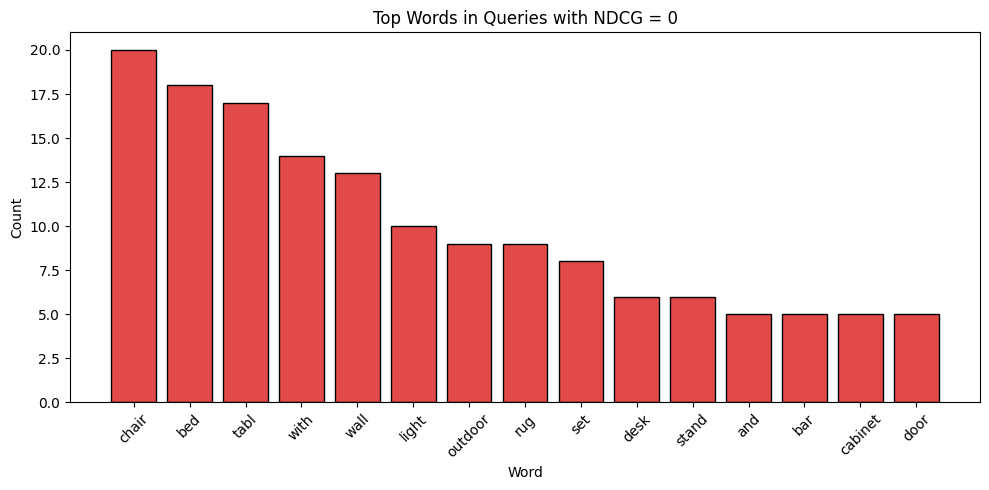

In [ ]:
# Task 5b: Identify failing queries
# YOUR CODE HERE
# Find queries with ndcg == 0
failing_queries = ndcg_results_df[ndcg_results_df['ndcg'] == 0]['query']

# Tokenize and count word frequencies across these queries
from collections import Counter

all_words = []
for q in failing_queries:
    all_words.extend(snowball_tokenize(q))
word_counts = Counter(all_words)

# Show top 15 most common words in failing queries
import matplotlib.pyplot as plt

top_words = word_counts.most_common(15)
words, counts = zip(*top_words)

plt.figure(figsize=(10,5))
plt.bar(words, counts, color="#e24a4a", edgecolor="black")
plt.title("Top Words in Queries with NDCG = 0")
plt.xlabel("Word")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Many queries with ndcg = 0 suggest the search function was unable to retrieve any relevant products for these queries.
# Chair, bed, tabl have the highest counts of words with multiple NDCGs of 0

### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

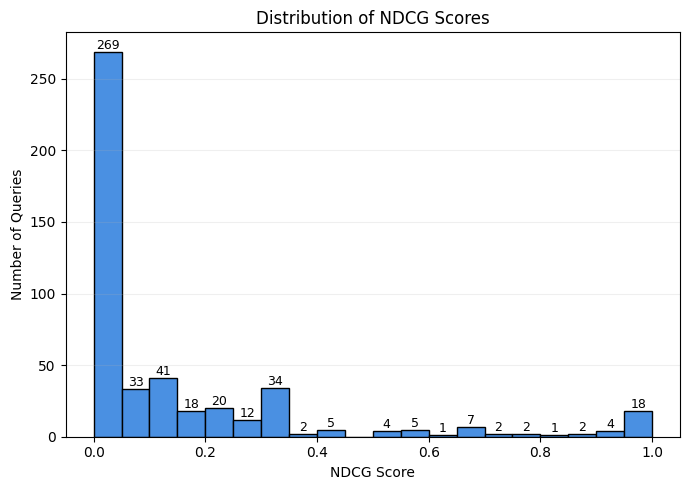

In [40]:
# Task 5c: Analyze the distribution

import matplotlib.pyplot as plt

# Plot a histogram of the NDCG scores
plt.figure(figsize=(7, 5))
n, bins, patches = plt.hist(ndcg_results_df['ndcg'], bins=20, color="#4a90e2", edgecolor="black")
plt.title("Distribution of NDCG Scores")
plt.xlabel("NDCG Score")
plt.ylabel("Number of Queries")

# Annotate each histogram bin
for count, bin_left, bin_right in zip(n, bins[:-1], bins[1:]):
    # Compute position at the top-center of each bar
    bin_center = (bin_left + bin_right) / 2
    if count > 0:
        plt.text(bin_center, count, f"{int(count)}", ha='center', va='bottom', fontsize=9, color="black")

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [59]:
# Task 6a: Index product_class field 
def search_products_three_fields(
    query,
    top_k=10,
    weight_name=0.5,
    weight_class=0.5,
    weight_descr=0.5,
    products_df=None  # Optional explicit parameter for products DataFrame
):
    """
    Search over product_name, product_class, and product_description for the given query.
    Returns top_k product_ids ranked by simple matching.
    A single weight is used for each field, applied to any match (substring or token overlap).
    Uses the Snowball tokenizer for better matching/normalization.
    """
    # If products_df is None, fall back to global (backwards compatible), else use the explicit one
    if products_df is None:
        try:
            products_df = df_products
        except NameError:
            raise ValueError("df_products is not defined. Please supply the products_df argument.")

    query_tokens = snowball_tokenize(query)
    query_text = str(query).lower()

    def score_row(row):
        name = str(row.get('product_name', ''))
        prod_class = str(row.get('product_class', ''))
        prod_descr = str(row.get('product_description', ''))
        score = 0.0

        name_tokens = snowball_tokenize(name)
        class_tokens = snowball_tokenize(prod_class)
        descr_tokens = snowball_tokenize(prod_descr)

        if (
            query_text in name.lower()
            or any(q_tok in name_tokens for q_tok in query_tokens)
        ):
            score += weight_name

        if (
            query_text in prod_class.lower()
            or any(q_tok in class_tokens for q_tok in query_tokens)
        ):
            score += weight_class

        if (
            query_text in prod_descr.lower()
            or any(q_tok in descr_tokens for q_tok in query_tokens)
        ):
            score += weight_descr

        return score

    products_df = products_df.copy()
    products_df["score"] = products_df.apply(score_row, axis=1)

    results = (
        products_df
        .sort_values("score", ascending=False)
        .loc[products_df["score"] > 0]
        .head(top_k)
    )
    return results[["product_id", "product_name", "product_class", "score"]]


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [60]:
# Task 6b: Evaluate three-field search
# Evaluate on all queries
ndcg_results_df = evaluate_search(
    search_products_three_fields,
    df_products,
    df_queries,
    df_labels,
    k=10,
    verbose=True
)

ndcg_results_df.head()
# YOUR CODE HERE


Evaluated 480 queries
Mean NDCG@10: 0.1906


,query_id,query,ndcg
0,0,salon chair,0.533857
1,1,smart coffee table,0.071329
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.333333
4,4,chair and a half recliner,0.000000


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [63]:
# Task 6c: Compare to baseline
# For comparison, run the baseline search and compute NDCG per query
ndcg_baseline_df = evaluate_search(
    simple_search_func,
    df_products,
    df_queries,
    df_labels,
    k=10,
    verbose=False
)

# Merge baseline and three-field search NDCG for side-by-side comparison
comparison_df = ndcg_baseline_df.rename(columns={'ndcg': 'ndcg_baseline'}).merge(
    ndcg_results_df.rename(columns={'ndcg': 'ndcg_three_fields'}),
    on=['query_id', 'query'],
    how='inner'
)

# Compute difference in NDCG for each query
comparison_df['ndcg_diff'] = comparison_df['ndcg_three_fields'] - comparison_df['ndcg_baseline']

# Queries that improved
improved_df = comparison_df[comparison_df['ndcg_diff'] > 0]
print("Queries that improved (Top 10):")
display(improved_df.sort_values('ndcg_diff', ascending=False).head(10))

# Queries that degraded
degraded_df = comparison_df[comparison_df['ndcg_diff'] < 0]
print("Queries that degraded (Top 10):")
display(degraded_df.sort_values('ndcg_diff').head(10))

# Optionally, show queries with no change
no_change_df = comparison_df[comparison_df['ndcg_diff'] == 0]
print(f"\n# Improved: {len(improved_df)} | Degraded: {len(degraded_df)} | No change: {len(no_change_df)}")


# YOUR CODE HERE


Queries that improved (Top 10):


,query_id,query,ndcg_baseline,ndcg_three_fields,ndcg_diff
227,231,anti fatigue mat,0.000000,0.902621,0.902621
300,305,ligth bulb,0.333333,1.000000,0.666667
235,239,bathroom single faucet,0.000000,0.654809,0.654809
432,438,indoor water fountain,0.000000,0.589044,0.589044
59,59,broadway lever,0.333333,0.886947,0.553613
256,260,retractable side awning,0.000000,0.543766,0.543766
30,30,3 1/2 inch drawer pull,0.000000,0.515705,0.515705
332,337,iittala bowl,0.184382,0.686423,0.502041
216,220,sheets for twinxl,0.071329,0.559440,0.488111
149,149,mid century modern,0.056527,0.529635,0.473108


Queries that degraded (Top 10):


,query_id,query,ndcg_baseline,ndcg_three_fields,ndcg_diff
223,227,owl,1.000000,0.000000,-1.000000
244,248,surge protector,0.868795,0.000000,-0.868795
119,119,welcome sign,1.000000,0.333333,-0.666667
224,228,bee,1.000000,0.339160,-0.660840
199,202,full mattress padded liner,0.553146,0.000000,-0.553146
127,127,wine bar,0.528964,0.000000,-0.528964
228,232,storage dresser,0.699215,0.184382,-0.514833
11,11,ombre rug,0.912530,0.430712,-0.481818
274,278,parakeet toy,0.559440,0.092424,-0.467016
457,464,cake cutlery,0.902621,0.446854,-0.455768



# Improved: 212 | Degraded: 99 | No change: 169


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [68]:
# Task 7a: Extract product type, theme, material, color, and any other information you deem relevant from the query

import json

class QueryInfo(BaseModel):
    """Structured representation of extracted query information."""

    product_type: str = Field(
        description="Main type of product (e.g. 'rug', 'sofa', 'table')"
    )

    theme: str | None = Field(
        default=None,
        description="Theme or subject (e.g. 'star wars', 'disney', 'modern')"
    )

    material: str | None = Field(
        default=None,
        description="Material or fabric (e.g. 'wood', 'metal', 'leather')"
    )

    color: str | None = Field(
        default=None,
        description="Primary color(s) (e.g. 'blue', 'green', 'red')"
    )

    style: str | None = Field(
        default=None,
        description="Style or aesthetic (e.g. 'modern', 'contemporary', 'rustic')"
    )

    other: str | None = Field(
        default=None,
        description="Any other important information extracted from the query"
    )

def extract_query_info(query: str) -> QueryInfo:
    """
    Use LiteLLM with a structured output schema to extract product type, theme, material, color, and other info.
    """
    # Prompt template for the LLM
    prompt = f"Extract product type, theme, material, color, style, and other info from this search query. Return JSON with keys: product_type, theme, material, color, style, other. Use null for missing values.\n\nQuery: \"{query}\""

    # Call LiteLLM with simple completion -- assuming a working LiteLLM OpenAI-compatible setup
    # You may configure litellm with your LTE API key as needed elsewhere in the notebook.
    result = litellm.completion(
        model="gemini/gemini-2.5-flash",
        messages=[{"role": "user", "content": prompt}],
        response_format= QueryInfo
    )
    # Parse structured JSON output
    try:
        query_info = QueryInfo.model_validate_json(result.choices[0].message.content)
        return query_info
    except Exception as e:
        print("Failed to parse LLM result:", e)
        return QueryInfo(product_type="unknown")




In [71]:
# Test your query understanding function by running it against these test queries
test_queries = [
    "star wars rug",
    "wooden coffee table",
    "blue leather sofa",
    "modern metal bookshelf"
]

results = []
for q in test_queries:
    results.append(extract_query_info(q))
    
print(results)

[QueryInfo(product_type='rug', theme='star wars', material=None, color=None, style=None, other=None), QueryInfo(product_type='coffee table', theme=None, material='wood', color=None, style=None, other=None), QueryInfo(product_type='sofa', theme=None, material='leather', color='blue', style=None, other=None), QueryInfo(product_type='bookshelf', theme=None, material='metal', color=None, style='modern', other=None)]


### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [75]:
# Task 7b: Create an LLM-enhanced search

# YOUR CODE HERE
def llm_enhanced_search(query: str, products_df: pd.DataFrame = None, alpha=2.0) -> pd.DataFrame:
    """
    Perform an LLM-enhanced search by extracting query info and boosting matching product types.

    Args:
        query (str): The user search query.
        products_df (pd.DataFrame): DataFrame of products with columns including 'product_class'.
        alpha (float): Boost value to add to the score of products matching the extracted product type.

    Returns:
        pd.DataFrame: Results DataFrame with original info plus boosted scores and ranks.
    """
    # Extract product type etc.
    query_info = extract_query_info(query)
    product_type = query_info.product_type
    product_type = product_type.lower() if product_type else None

    # Compute a simple relevance score (match on product name or description)
    def simple_score(row):
        score = 0
        if query.lower() in str(row['product_name']).lower():
            score += 1
        if query.lower() in str(row['product_description']).lower():
            score += 1
        return score

    # If products_df is None, fall back to global (backwards compatible), else use the explicit one
    if products_df is None:
        try:
            products_df = df_products
        except NameError:
            raise ValueError("df_products is not defined. Please supply the products_df argument.")

    results = products_df.copy()
    results['score'] = results.apply(simple_score, axis=1)

    # If we identified a product type, boost relevant matches in product_class
    if product_type and product_type != "unknown":
        # Boost score for products whose class contains the product_type term (case-insensitive)
        matches = results['product_class'].fillna("").str.lower().str.contains(product_type)
        results.loc[matches, 'score'] += alpha

    # Sort results by score descending and add rank
    results = results.sort_values(by="score", ascending=False)
    results['rank'] = range(1, len(results) + 1)
    return results


llm_results_df = evaluate_search(
    llm_enhanced_search,
    df_products,
    df_queries,
    df_labels,
    k=10,
    verbose=True
)




Failed to parse LLM result: 1 validation error for QueryInfo
  JSON input should be string, bytes or bytearray [type=json_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.12/v/json_type
Evaluated 480 queries
Mean NDCG@10: 0.2652


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
